# Communicating Results
## Set up data

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv('cereal.csv', sep=';')

#to demonstrate continuous and categorical predictions, we will keep rating numerical, as well as make a ranked classification system

df.rating.describe()

df['rate_class'] = pd.cut(df.rating, 2, labels=['bad','good'])

In [178]:
df.rate_class.value_counts()

bad     63
good    11
dtype: int64

In [179]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,rate_class
0,100%Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973,good
1,100%NaturalBran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679,bad
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505,good
3,All-BranwithExtraFiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912,good
4,AppleCinnamonCheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,bad


In [180]:
df.isnull().sum() #no nulls
df.dtypes #all seem okay
len(df)

74

## Build models

In [189]:
#import models
from sklearn.linear_model import LinearRegression, LogisticRegression

linreg = LinearRegression()
logreg = LogisticRegression()

#split data for training/testing
from sklearn.cross_validation import train_test_split

cols = list(df.columns)
#for simplicity's sake, we will remove columns with object type
cols.remove('name')
cols.remove('mfr')
cols.remove('type')
#remove our target variables
cols.remove('rating')
cols.remove('rate_class')

#define features and targets
X = df[cols]
y_lin = df.rating
y_log = df.rate_class

#split data
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y_lin)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.5)

#train models
linreg.fit(X_train_lin, y_train_lin)
logreg.fit(X_train_log, y_train_log)

#get predictions from test data
y_pred_lin = linreg.predict(X_test_lin)

y_pred_log = logreg.predict(X_test_log)
y_probs_log = logreg.predict_proba(X_test_log)

## Regression Metrics

#### .score

In [191]:
print 'linear regression score: '
print linreg.score(X_test_lin, y_test_lin)
print
print 'logistic regression score: '
print logreg.score(X_test_log, y_test_log)

linear regression score: 
1.0

logistic regression score: 
0.891891891892


#### cross validation score

In [193]:
from sklearn.cross_validation import cross_val_score

#linear regression - use error (need to define type)
#note - RMSE is not an accuracy metric in cross_val_score. Considering taking square root before explaining to clients.
#note - need to make mse non-negative - this is where numpy behaves oddly, making mse negative

mse = cross_val_score(linreg, X, y_lin, scoring='mean_squared_error', cv=10).mean() 
rmse = np.sqrt(abs(mse)) 

print 'linear regression cross-val score: '
print 'mse: ' + str(mse)
print 'rmse: ' + str(rmse)

#logistic regression - use accuracy (can choose other metrics)
print
print 'logistic regression cross-val score: '
print cross_val_score(logreg, X, y_log, scoring='accuracy', cv=10).mean()


linear regression cross-val score: 
mse: -1.34686834193e-13
rmse: 3.66997049298e-07

logistic regression cross-val score: 
0.933531746032


## Classification Metrics

In [252]:
pd.DataFrame({'Predicted Neg':['FN','TN'],'Predicted Pos':['TP','FP']}, index=['Actual Pos','Actual Neg'])

,Predicted Neg,Predicted Pos
Actual Pos,FN,TP
Actual Neg,TN,FP


### TPR / FPR 
- True Positive Rate: True Positives (Predicted positives that are actually positive) / Total Actual Positives
    - TP / AP (aka FN + TP)
    - Same as recall
- False Positive Rate: False Positives (Predicted positives that are actually negative) / Total Actual Negatives
    - FP / AN (aka TN + FP)
    - Same as (1 - Specificity)
    
### Sensitivity / Specificity
- Sensitivity: True Positives / Total Actual Positives
    - TP / AP (aka FN + TP)
    - Same as TPR
- Specificity: True Negatives / Total Actual Negatives
    - TN / AN (aka TN + FP)
    - Same as (1 - FPR)

### Precision/Recall
- Recall: True Positives / Total Actual Positives
    - TP / AP (aka FN + TP)
    - Same as TPR/sensitivity
- Precision: True Positives / Total Predicted Positives
    - TP / PP (aka TP + FP)

### Accuracy
- Correct Predictions (TP + TN) / Total Predictions (TP + TN + FP + FN)

### F1 Score
- Harmonic mean of precision and recall
- 2 / (1/prec)+(1/recall)

![img]('confmatrix.png')

#### Confusion Matrix

In [266]:
#only for classification
from sklearn.metrics import confusion_matrix

#make confusion matrix
cm = confusion_matrix(y_test_log, y_pred_log)

#make it into a pretty data frame
print 'logistic regression confusion matrix: '
cm_df = pd.DataFrame(cm, columns=(logreg.classes_ + ' PRED'), index=(logreg.classes_ + ' TRUE'))

cm_df

logistic regression confusion matrix: 


,bad PRED,good PRED
bad TRUE,29,1
good TRUE,3,4


#### Classification Report

In [195]:
#only for classification
from sklearn.metrics import classification_report

print 'logistic regression classification report: '
cr = classification_report(y_test_log, y_pred_log)
print cr


logistic regression classification report: 
             precision    recall  f1-score   support

        bad       0.91      0.97      0.94        30
       good       0.80      0.57      0.67         7

avg / total       0.89      0.89      0.88        37



#### Accuracy Score

Only for classification

In [256]:
from sklearn.metrics import accuracy_score

print 'logistic regression accuracy score: '
print accuracy_score(y_test_log, y_pred_log) #gives ratio of true positives
print accuracy_score(y_test_log, y_pred_log, normalize=False) #gives count of true positives

#score is the same as .score for logistic regression model

logistic regression accuracy score: 
0.891891891892
33


### ROC-AUC Scores and Curve
Compares TPR (SENSITIVITY) and FPR (1-SPECIFICITY)

Compares our correct predictions (both pos. and neg.) to total actual values

Works on binary classification only (although could plot multiple curves on same graph for multiclass problems)

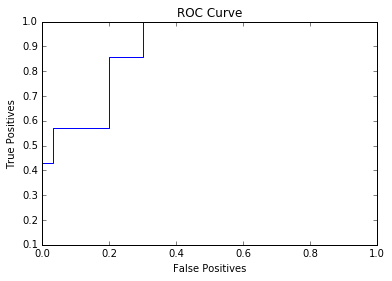

In [253]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

#to use the roc curve, you will need to use only the second column of our y_probs array
#this is easy if you transpose it and take the second item (index 1)
y_scores = y_probs_log.T[1]

#get parameters for plotting
FPR, TPR, threshold = roc_curve(y_test_log, y_scores, pos_label='good')
plt.plot(FPR, TPR)
plt.title('ROC Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives')

In [254]:
#for roc_auc_score, we need our true values to be represented as binary (we managed this with pos_label above)
y_test_binary = y_test_log == 'good'

#get roc_auc_score
roc_auc_score(y_test_binary, y_scores)

#how close is it to 1.0? That would be perfect
#see if adjusting your model can create a curve with higher AUC

0.89523809523809517

#### Precision-Recall Scores and Curve
Compares PRECISION vs. RECALL

Compares our True Positives to all positives (both total actual and total pred.)

Again, binary classification only - with some meddling can do multiclass predictions

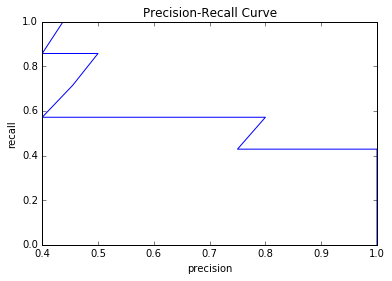

In [269]:
from sklearn.metrics import average_precision_score, precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test_log, y_scores, pos_label='good')
plt.plot(precision,recall)
plt.title('Precision-Recall Curve')
plt.xlabel('precision')
plt.ylabel('recall')